In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ast
import json
import os
import numpy as np

import tqdm

import pdb

uniprot_tsv_path = './data/uniprot.tsv'
df_uniprot = pd.read_csv(uniprot_tsv_path, sep='\t')

hpa_csv_path = './data/hpa_data_resized.csv'
df_hpa_images = pd.read_csv(hpa_csv_path)

hpa_location_path = './data/subcellular_location.tsv'
df_location = pd.read_csv(hpa_location_path, sep='\t')

labels_nuc_cyto = np.array(['nuc', 'cyto'])

def add_short_go_ids(df, top_n = 8):
    labels = np.concatenate(df['GO id'].str.split(';').tolist())

    ulabels = np.unique(labels)

    counts = list()

    for ulabel in ulabels:
        count = np.sum(ulabel == labels)
        counts += [count]

    counts = np.array(counts)

#     plt.bar(x = range(len(ulabels)), height = counts)

    top_inds = counts.argsort()[-top_n:][::-1]
    keep_labels = ulabels[top_inds]

    for i in tqdm.tqdm(range(len(df))):
        label_inds = [label in df.loc[i]['GO id'] for label in keep_labels]
        df.loc[i,'GO id short'] = ';'.join(keep_labels[label_inds])

    return df

def add_nuc_go_ids(df):
    labels = np.concatenate(df['GO id'].str.split(';').tolist())

    ulabels = np.unique(labels)

    
    for i in tqdm.tqdm(range(len(df))):
        
        go_ids = df.loc[i]['GO id']
        
        has_nuc = np.array([go_id[0:3].lower() == 'nuc' for go_id in go_ids.split(';')])
        
        label_inds = np.array([np.any(has_nuc), np.any(~has_nuc)])
        
        if np.any(label_inds):
            df.loc[i,'nuc or cyto'] = ';'.join(labels_nuc_cyto[label_inds])

    return df

def add_uniprot_go_ids_short(df):
    go_terms = df['Uniprot GO id'].str.split('; ').tolist()
    
    
    
    nuc_locs = ['nucleus [GO:0005634]', 'nucleoplasm [GO:0005654]']
    cyto_locs = ['cytosol [GO:0005829]', 'cytoplasm [GO:0005737]', 
                 'plasma membrane [GO:0005886]', 'extracellular exosome [GO:0070062]', 
                 'integral component of membrane [GO:0016021]', 'membrane [GO:0016020]',
                 'mitochondrion [GO:0005739]']
    
    for i in tqdm.tqdm(range(len(df))):
        
        in_nuc = False
    
        
        for nuc_loc in nuc_locs:
            try:
                if nuc_loc in df.loc[i, 'Uniprot GO id']:
                    in_nuc = True
                    break
            except:
                pass

        in_cyto = False
        for cyto_loc in cyto_locs:
            try:
                if cyto_loc in df.loc[i, 'Uniprot GO id']:
                    in_cyto = True
                    break
            except:
                pass
            
        label_inds = [in_nuc, in_cyto]

        if np.any(label_inds):
            df.loc[i,'Uniprot GO id nuc or cyto'] = ';'.join(labels_nuc_cyto[label_inds])
        
    return df


In [18]:
np.random.seed(0)



#copy the GO ids from the location file to the master file
df_location_tmp = df_location.rename(columns={'Gene': 'ENSG'})
df_hpa_images = df_hpa_images.merge(df_location_tmp[['ENSG','GO id']], on='ENSG', how='left')

df_uniprot_tmp = df_uniprot.rename(columns={'Entry': 'protID', 'Gene ontology (cellular component)': 'Uniprot GO id'})
df_hpa_images = df_hpa_images.merge(df_uniprot_tmp[['protID', 'Uniprot GO id']], on='protID', how='left')


df_hpa_images_tmp = df_hpa_images.rename(columns={'protID': 'Entry'})
df_uniprot = df_uniprot.merge(df_hpa_images_tmp[['Entry','GO id']], on='Entry', how='left')

#Add in the nucleotide sequences
uensgs = np.unique(df_hpa_images['ENSG'])

df_hpa_images.loc[:, 'Sequence_nucleotide'] = ''

df_hpa_images = add_uniprot_go_ids_short(df_hpa_images)
df_hpa_images = add_nuc_go_ids(df_hpa_images)    
df_hpa_images = add_short_go_ids(df_hpa_images, top_n = 8)

train_test_validate = [0.8, 0.1, 0.1]
train_test_validate_names = ['train', 'test', 'validate']

train_test_validate_end = np.cumsum(train_test_validate)
train_test_validate_start = np.hstack([[0], train_test_validate_end[0:3]])

genes = df_uniprot['Entry']
ugenes = np.unique([str(gene) for gene in genes])
rand_vals = np.random.random(len(ugenes))

df_uniprot_splits = list()

for i in tqdm.tqdm(range(0, len(train_test_validate))):
    inds_bool = (rand_vals > train_test_validate_start[i]) & (rand_vals <= train_test_validate_end[i])
    inds_split  = np.where(inds_bool)[0]
    
    
    df_row_inds = np.nonzero(np.in1d(genes,ugenes[inds_split]))[0]
    df_uniprot_split = df_uniprot.iloc[df_row_inds]
    
    
    df_uniprot_name = uniprot_tsv_path[0:-4] + '_' + train_test_validate_names[i] + '.tsv'
    df_uniprot_split.to_csv(df_uniprot_name, sep='\t')    
    
    
    df_hpa_inds = np.where(np.in1d(df_hpa_images['protID'], df_uniprot_split['Entry']))[0]
    df_hpa_split = df_hpa_images.iloc[df_hpa_inds]
    
    df_hpa_name = hpa_csv_path[0:-4] + '_' + train_test_validate_names[i] + '.csv'
    df_hpa_split.to_csv(df_hpa_name)    
    
    print('{}: {} genes, {} images'.format(df_uniprot_name, len(df_uniprot_split), len(df_hpa_split)))
    
print('{} genes listed'.format(len(df_uniprot['Gene names'])))
print('{} unique genes'.format(len(ugenes)))

 33%|███▎      | 1/3 [02:23<04:46, 143.19s/it]

./data/uniprot_train.tsv: 67532 genes, 59917 images


 67%|██████▋   | 2/3 [02:43<01:21, 81.82s/it] 

./data/uniprot_test.tsv: 8513 genes, 7606 images


100%|██████████| 3/3 [03:00<00:00, 60.12s/it]

./data/uniprot_validate.tsv: 8329 genes, 7345 images
84374 genes listed
20303 unique genes


In [11]:
df_train = pd.read_csv('./data/hpa_data_resized_train.csv')
df_validate = pd.read_csv('./data/hpa_data_resized_validate.csv')

In [12]:
ensg_train = np.unique(df_train['protID'])
ensg_validate = np.unique(df_validate['protID'])

for i in ensg_train:
    for j in ensg_validate:
        if i == j:
            print(i + ':' + j)

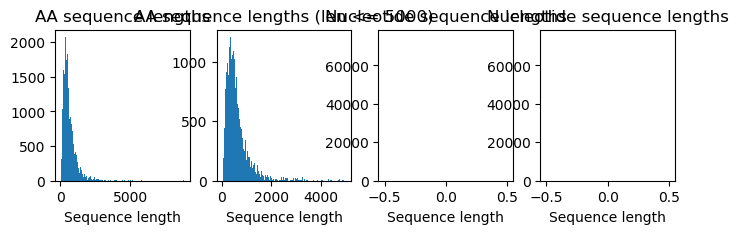

In [5]:
seqlen = np.array([len(seq) for seq in df_hpa_images['Sequence']])
seqlen_nuc = np.array([len(seq) for seq in df_hpa_images['Sequence_nucleotide']])

# counts, bin_edges = np.histogram(seqlen, 500)

plt.figure(figsize=(8, 2), dpi=100, facecolor='w', edgecolor='k')

plt.subplot(1, 4, 1)

plt.hist(seqlen, bins=500)  # arguments are passed to np.histogram
plt.title("AA sequence lengths")
plt.xlabel('Sequence length')
# plt.show()

plt.subplot(1, 4, 2)

plt.hist(seqlen[seqlen <= 5000], bins=500)
plt.title("AA sequence lengths (len <= 5000)")
plt.xlabel('Sequence length')

plt.subplot(1, 4, 3)

plt.hist(seqlen_nuc, bins=500)  # arguments are passed to np.histogram
plt.title("Nucleotide sequence lengths")
plt.xlabel('Sequence length')

plt.subplot(1, 4, 4)

plt.hist(seqlen_nuc[seqlen_nuc<=500000], bins=500)  # arguments are passed to np.histogram
plt.title("Nucleotide sequence lengths")
plt.xlabel('Sequence length')


plt.show()

In [6]:
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer

uniprot_tsv_path = './data/uniprot.tsv'
df = pd.read_csv(uniprot_tsv_path, sep='\t')

df = df.dropna(subset=['Gene ontology (cellular component)'])
df = df.reset_index(drop=True)

mlb = MultiLabelBinarizer()
some_hot_targets = mlb.fit_transform(df['Gene ontology (cellular component)'].str.split('; ').tolist())
df['GOsomehot'] = pd.Series(tuple(some_hot_targets.astype(np.float32)))

# keep only the K most frequent location annotations, and the data annotated with these locs

targets = np.array(list(df['GOsomehot'].values))
abundances = targets.sum(axis=0)

N_feats=25
top_inds = abundances.argsort()[-N_feats:][::-1]

df['GOsomehotTop'] = df['GOsomehot'].apply(lambda x: x[top_inds])
df['GOsomehotTopkeep'] = df['GOsomehotTop'].apply(lambda x: np.any(x>0))
df = df.query('GOsomehotTopkeep == True')

mlb.classes_[top_inds]


array(['nucleus [GO:0005634]', 'cytosol [GO:0005829]',
       'plasma membrane [GO:0005886]', 'cytoplasm [GO:0005737]',
       'integral component of membrane [GO:0016021]',
       'nucleoplasm [GO:0005654]', 'extracellular exosome [GO:0070062]',
       'membrane [GO:0016020]', 'extracellular region [GO:0005576]',
       'integral component of plasma membrane [GO:0005887]',
       'extracellular space [GO:0005615]', 'mitochondrion [GO:0005739]',
       'endoplasmic reticulum [GO:0005783]',
       'Golgi apparatus [GO:0005794]',
       'endoplasmic reticulum membrane [GO:0005789]',
       'nucleolus [GO:0005730]', 'Golgi membrane [GO:0000139]',
       'perinuclear region of cytoplasm [GO:0048471]',
       'cell surface [GO:0009986]',
       'intracellular membrane-bounded organelle [GO:0043231]',
       'protein complex [GO:0043234]', 'intracellular [GO:0005622]',
       'cell junction [GO:0030054]', 'centrosome [GO:0005813]',
       'mitochondrial inner membrane [GO:0005743]'], dtype=o

In [7]:
len(np.in1d(df_hpa_images['protID'], df_uniprot_split['Entry']))

74868

In [8]:
np.hstack([[0], train_test_validate[0:3]])

array([0. , 0.8, 0.1, 0.1])

<BarContainer object of 5 artists>

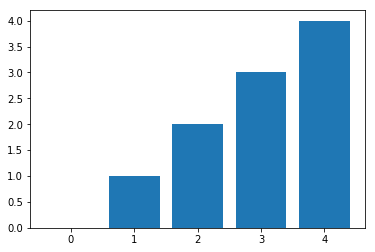

In [9]:
plt.bar(x = range(5), height = [0,1,2,3,4])

In [3]:

#copy the GO ids from the location file to the master file
df_location_tmp = df_location.rename(columns={'Gene': 'ENSG'})
df_hpa_images = df_hpa_images.merge(df_location_tmp[['ENSG','GO id']], on='ENSG', how='left')

df_hpa_images_tmp = df_hpa_images.rename(columns={'protID': 'Entry'})
df_uniprot = df_uniprot.merge(df_hpa_images_tmp[['Entry','GO id']], on='Entry', how='left')

#Add in the nucleotide sequences
uensgs = np.unique(df_hpa_images['ENSG'])

df_hpa_images.loc[:, 'Sequence_nucleotide'] = ''


In [57]:
df_uniprot.loc[df_uniprot['Protein names'] == 'Protein quaking (Hqk) (HqkI)']

,Entry,Status,Organism,Entry name,Gene names,Protein names,Ensembl transcript,Sequence,Gene ontology (cellular component),Gene ontology (biological process),GO id
84367,Q96PU8,reviewed,Homo sapiens (Human),QKI_HUMAN,QKI HKQ,Protein quaking (Hqk) (HqkI),ENST00000275262 [Q96PU8-6];ENST00000361195 [Q9...,MVGEMETKEKPKPTPDYLMQLMNDKKLMSSLPNFCGIFNHLERLLD...,cytoplasm [GO:0005737]; nucleus [GO:0005634],3'-UTR-mediated mRNA destabilization [GO:00611...,Nucleoplasm (GO:0005654)
84368,Q96PU8,reviewed,Homo sapiens (Human),QKI_HUMAN,QKI HKQ,Protein quaking (Hqk) (HqkI),ENST00000275262 [Q96PU8-6];ENST00000361195 [Q9...,MVGEMETKEKPKPTPDYLMQLMNDKKLMSSLPNFCGIFNHLERLLD...,cytoplasm [GO:0005737]; nucleus [GO:0005634],3'-UTR-mediated mRNA destabilization [GO:00611...,Nucleoplasm (GO:0005654)
84369,Q96PU8,reviewed,Homo sapiens (Human),QKI_HUMAN,QKI HKQ,Protein quaking (Hqk) (HqkI),ENST00000275262 [Q96PU8-6];ENST00000361195 [Q9...,MVGEMETKEKPKPTPDYLMQLMNDKKLMSSLPNFCGIFNHLERLLD...,cytoplasm [GO:0005737]; nucleus [GO:0005634],3'-UTR-mediated mRNA destabilization [GO:00611...,Nucleoplasm (GO:0005654)
84370,Q96PU8,reviewed,Homo sapiens (Human),QKI_HUMAN,QKI HKQ,Protein quaking (Hqk) (HqkI),ENST00000275262 [Q96PU8-6];ENST00000361195 [Q9...,MVGEMETKEKPKPTPDYLMQLMNDKKLMSSLPNFCGIFNHLERLLD...,cytoplasm [GO:0005737]; nucleus [GO:0005634],3'-UTR-mediated mRNA destabilization [GO:00611...,Nucleoplasm (GO:0005654)
84371,Q96PU8,reviewed,Homo sapiens (Human),QKI_HUMAN,QKI HKQ,Protein quaking (Hqk) (HqkI),ENST00000275262 [Q96PU8-6];ENST00000361195 [Q9...,MVGEMETKEKPKPTPDYLMQLMNDKKLMSSLPNFCGIFNHLERLLD...,cytoplasm [GO:0005737]; nucleus [GO:0005634],3'-UTR-mediated mRNA destabilization [GO:00611...,Nucleoplasm (GO:0005654)
84372,Q96PU8,reviewed,Homo sapiens (Human),QKI_HUMAN,QKI HKQ,Protein quaking (Hqk) (HqkI),ENST00000275262 [Q96PU8-6];ENST00000361195 [Q9...,MVGEMETKEKPKPTPDYLMQLMNDKKLMSSLPNFCGIFNHLERLLD...,cytoplasm [GO:0005737]; nucleus [GO:0005634],3'-UTR-mediated mRNA destabilization [GO:00611...,Nucleoplasm (GO:0005654)


In [62]:
hpa_location_path = './data/subcellular_location.tsv'
df_location = pd.read_csv(hpa_location_path, sep='\t')

df_location.loc[df_location['Gene name'] == 'QKI']

,Gene,Gene name,Reliability,Enhanced,Supported,Approved,Uncertain,Single-cell variation intensity,Single-cell variation spatial,Cell cycle dependency,GO id
2920,ENSG00000112531,QKI,Supported,NaN,Nucleoplasm,NaN,NaN,NaN,NaN,NaN,Nucleoplasm (GO:0005654)


In [11]:
df_location.loc[np.where(df_location['Gene name'] == 'CCNB1')[0]]

,Gene,Gene name,Reliability,Enhanced,Supported,Approved,Uncertain,Single-cell variation intensity,Single-cell variation spatial,Cell cycle dependency,GO id
4755,ENSG00000134057,CCNB1,Enhanced,Cytosol,NaN,NaN,NaN,Cytosol,NaN,N/A (custom data),Cytosol (GO:0005829)


In [41]:
go_terms = np.hstack(df_uniprot['Gene ontology (cellular component)'].str.split(';').tolist())
go_terms = [go_term.lstrip() for go_term in go_terms]
u_go_terms, u_go_term_counts = np.unique(go_terms, return_counts=True)
                       
u_go_terms

array(['3-methylcrotonyl-CoA carboxylase complex, mitochondrial [GO:0002169]',
       '3M complex [GO:1990393]',
       '4-aminobutyrate transaminase complex [GO:0032144]', ...,
       'zonula adherens [GO:0005915]', 'zymogen granule [GO:0042588]',
       'zymogen granule membrane [GO:0042589]'], dtype='<U101')

<BarContainer object of 1625 artists>

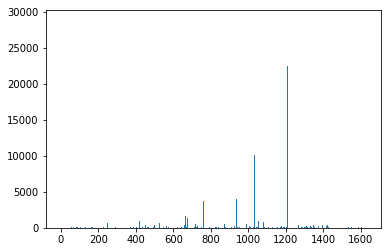

In [42]:
plt.bar(range(len(u_go_term_counts)), go_term_counts)

In [53]:
count_order = np.argsort(go_term_counts)[::-1]

print(u_go_term_counts[count_order])
print(u_go_terms[count_order[0:20]])


[28751 27269 22411 ...     1     1     1]
['nucleus [GO:0005634]' 'cytosol [GO:0005829]' 'nucleoplasm [GO:0005654]'
 'cytoplasm [GO:0005737]' 'plasma membrane [GO:0005886]'
 'extracellular exosome [GO:0070062]'
 'integral component of membrane [GO:0016021]' 'membrane [GO:0016020]'
 'mitochondrion [GO:0005739]' 'nan' 'nucleolus [GO:0005730]'
 'extracellular region [GO:0005576]' 'Golgi apparatus [GO:0005794]'
 'integral component of plasma membrane [GO:0005887]'
 'intracellular membrane-bounded organelle [GO:0043231]'
 'endoplasmic reticulum [GO:0005783]' 'extracellular space [GO:0005615]'
 'endoplasmic reticulum membrane [GO:0005789]'
 'perinuclear region of cytoplasm [GO:0048471]'
 'protein complex [GO:0043234]']


In [52]:
for u_go_term in u_go_terms:
    if 'nuc' in u_go_term:
        print(u_go_term)

Fanconi anaemia nuclear complex [GO:0043240]
NLS-dependent protein nuclear import complex [GO:0042564]
RIC1-RGP1 guanyl-nucleotide exchange factor complex [GO:0034066]
RNA nuclear export complex [GO:0042565]
condensed nuclear chromosome [GO:0000794]
condensed nuclear chromosome inner kinetochore [GO:0000941]
condensed nuclear chromosome kinetochore [GO:0000778]
condensed nuclear chromosome outer kinetochore [GO:0000942]
condensed nuclear chromosome, centromeric region [GO:0000780]
cytoplasmic periphery of the nuclear pore complex [GO:1990723]
cytoplasmic ribonucleoprotein granule [GO:0036464]
cytoplasmic side of nuclear pore [GO:1990876]
female germ cell nucleus [GO:0001674]
female pronucleus [GO:0001939]
guanyl-nucleotide exchange factor complex [GO:0032045]
host cell perinuclear region of cytoplasm [GO:0044220]
integral component of nuclear inner membrane [GO:0005639]
integral component of nuclear outer membrane [GO:0031309]
intracellular cyclic nucleotide activated cation channel co

In [26]:
df_hpa_split['RGB512px'][28]

'64099/1261_D3_1_RGB512px.png'

In [27]:
df_hpa_split

,Unnamed: 0,ENSG,protID,antibodyName,antigenSequence,cellLine,antibodyChannel,microtubuleChannel,nuclearChannel,segmentationChannel,...,RGB128px,RGB256px,RGB512px,RGB1024px,GO id,Uniprot GO id,Sequence_nucleotide,Uniprot GO id nuc or cyto,nuc or cyto,GO id short
28,28,ENSG00000101337,Q92544,HPA064099,EDYYVHLIADNLPVATRLELYSNRDSDDKKKEKDVQFEHGYRLGFT...,CACO-2,64099/1261_D3_1_green.jpg,64099/1261_D3_1_red.jpg,64099/1261_D3_1_blue.jpg,64099/1261_D3_1_segmentation.png,...,64099/1261_D3_1_RGB128px.png,64099/1261_D3_1_RGB256px.png,64099/1261_D3_1_RGB512px.png,64099/1261_D3_1_RGB1024px.png,Mitochondria (GO:0005739),early endosome [GO:0005769]; Golgi apparatus [...,,cyto,cyto,Mitochondria (GO:0005739)
29,29,ENSG00000101337,Q92544,HPA064099,EDYYVHLIADNLPVATRLELYSNRDSDDKKKEKDVQFEHGYRLGFT...,CACO-2,64099/1261_D3_3_green.jpg,64099/1261_D3_3_red.jpg,64099/1261_D3_3_blue.jpg,64099/1261_D3_3_segmentation.png,...,64099/1261_D3_3_RGB128px.png,64099/1261_D3_3_RGB256px.png,64099/1261_D3_3_RGB512px.png,64099/1261_D3_3_RGB1024px.png,Mitochondria (GO:0005739),early endosome [GO:0005769]; Golgi apparatus [...,,cyto,cyto,Mitochondria (GO:0005739)
30,30,ENSG00000101337,Q92544,HPA064099,EDYYVHLIADNLPVATRLELYSNRDSDDKKKEKDVQFEHGYRLGFT...,SiHa,64099/1164_H1_1_green.jpg,64099/1164_H1_1_red.jpg,64099/1164_H1_1_blue.jpg,64099/1164_H1_1_segmentation.png,...,64099/1164_H1_1_RGB128px.png,64099/1164_H1_1_RGB256px.png,64099/1164_H1_1_RGB512px.png,64099/1164_H1_1_RGB1024px.png,Mitochondria (GO:0005739),early endosome [GO:0005769]; Golgi apparatus [...,,cyto,cyto,Mitochondria (GO:0005739)
31,31,ENSG00000101337,Q92544,HPA064099,EDYYVHLIADNLPVATRLELYSNRDSDDKKKEKDVQFEHGYRLGFT...,SiHa,64099/1164_H1_2_green.jpg,64099/1164_H1_2_red.jpg,64099/1164_H1_2_blue.jpg,64099/1164_H1_2_segmentation.png,...,64099/1164_H1_2_RGB128px.png,64099/1164_H1_2_RGB256px.png,64099/1164_H1_2_RGB512px.png,64099/1164_H1_2_RGB1024px.png,Mitochondria (GO:0005739),early endosome [GO:0005769]; Golgi apparatus [...,,cyto,cyto,Mitochondria (GO:0005739)
32,32,ENSG00000101337,Q92544,HPA064099,EDYYVHLIADNLPVATRLELYSNRDSDDKKKEKDVQFEHGYRLGFT...,U-2 OS,64099/1174_H1_2_green.jpg,64099/1174_H1_2_red.jpg,64099/1174_H1_2_blue.jpg,64099/1174_H1_2_segmentation.png,...,64099/1174_H1_2_RGB128px.png,64099/1174_H1_2_RGB256px.png,64099/1174_H1_2_RGB512px.png,64099/1174_H1_2_RGB1024px.png,Mitochondria (GO:0005739),early endosome [GO:0005769]; Golgi apparatus [...,,cyto,cyto,Mitochondria (GO:0005739)
33,33,ENSG00000101337,Q92544,HPA064099,EDYYVHLIADNLPVATRLELYSNRDSDDKKKEKDVQFEHGYRLGFT...,U-2 OS,64099/1174_H1_3_green.jpg,64099/1174_H1_3_red.jpg,64099/1174_H1_3_blue.jpg,64099/1174_H1_3_segmentation.png,...,64099/1174_H1_3_RGB128px.png,64099/1174_H1_3_RGB256px.png,64099/1174_H1_3_RGB512px.png,64099/1174_H1_3_RGB1024px.png,Mitochondria (GO:0005739),early endosome [GO:0005769]; Golgi apparatus [...,,cyto,cyto,Mitochondria (GO:0005739)
68,68,ENSG00000163902,P04843,HPA026828,KVHYENNSPFLTITSMTRVIEVSHWGNIAVEENVDLKHTGAVLKGP...,A-431,26828/231_F9_1_green.jpg,26828/231_F9_1_red.jpg,26828/231_F9_1_blue.jpg,26828/231_F9_1_segmentation.png,...,26828/231_F9_1_RGB128px.png,26828/231_F9_1_RGB256px.png,26828/231_F9_1_RGB512px.png,26828/231_F9_1_RGB1024px.png,Endoplasmic reticulum (GO:0005783),cytosol [GO:0005829]; endoplasmic reticulum [G...,,cyto,cyto,
69,69,ENSG00000163902,P04843,HPA026828,KVHYENNSPFLTITSMTRVIEVSHWGNIAVEENVDLKHTGAVLKGP...,A-431,26828/231_F9_2_green.jpg,26828/231_F9_2_red.jpg,26828/231_F9_2_blue.jpg,26828/231_F9_2_segmentation.png,...,26828/231_F9_2_RGB128px.png,26828/231_F9_2_RGB256px.png,26828/231_F9_2_RGB512px.png,26828/231_F9_2_RGB1024px.png,Endoplasmic reticulum (GO:0005783),cytosol [GO:0005829]; endoplasmic reticulum [G...,,cyto,cyto,
70,70,ENSG00000163902,P04843,HPA026828,KVHYENNSPFLTITSMTRVIEVSHWGNIAVEENVDLKHTGAVLKGP...,U-2 OS,26828/232_F9_1_green.jpg,26828/232_F9_1_red.jpg,26828/232_F9_1_blue.jpg,26828/232_F9_1_segmentation.png,...,26828/232_F9_1_RGB128px.png,26828/232_F9_1_RGB256px.png,26828/232_F9_1_RGB512px.png